In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import numpy as np
import optax
import tensorflow_datasets as tfds
from typing import Any, Callable, Sequence, Optional

2022-03-25 17:15:04.515292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/home/adamo/miniconda3/envs/2541/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    features: Sequence[int]
#     features = (1000,1000,10)
    
    def setup(self):
        dense_layers, activations = [], []
        for layer_idx, feats in enumerate(self.features):
            dense_layers.append(nn.Dense(feats))
            activations.append(nn.relu)
        activations[-1] = nn.log_softmax
        self.dense_layers = dense_layers
        self.activations = activations
    
    def __call__(self,x):
        for layer_idx, layer in enumerate(self.dense_layers):
            x = layer(x)
            x = self.activations[layer_idx](x)
        return x
mlp = MLP(features=(1024,1024,10))

In [3]:
def cross_entropy_loss(*, logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
  return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [4]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [5]:
def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

In [6]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  params = mlp.init(rng, jnp.ones([1, 28*28*1]))['params']
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=mlp.apply, params=params, tx=tx)

In [7]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = mlp.apply({'params': params}, batch['image'])
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

In [8]:
@jax.jit
def eval_step(params, batch):
  logits = mlp.apply({'params': params}, batch['image'])
  return compute_metrics(logits=logits, labels=batch['label'])

In [9]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

In [10]:
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

In [11]:
train_ds, test_ds = get_datasets()
train_ds["image"] = train_ds["image"].reshape(-1,28*28*1)
test_ds["image"] = test_ds["image"].reshape(-1,28*28*1)

2022-03-25 17:15:05.925683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 17:15:05.925767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-25 17:15:05.925833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-25 17:15:05.925898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-03-25 17:15:05.925961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [12]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [13]:
learning_rate = 0.001
momentum = 0.9

In [14]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [15]:
num_epochs = 3
batch_size = 128

In [16]:
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))

train epoch: 1, loss: 1.2328, accuracy: 73.69
 test epoch: 1, loss: 0.58, accuracy: 86.45
train epoch: 2, loss: 0.4800, accuracy: 87.74
 test epoch: 2, loss: 0.39, accuracy: 89.69
train epoch: 3, loss: 0.3717, accuracy: 89.80
 test epoch: 3, loss: 0.33, accuracy: 90.96


# Spectrum Computation

In [17]:
import matplotlib.pyplot as plt
import time
import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

In [32]:
# make a generator that yields 1/10th and epoch
num_batches = train_ds["image"].shape[0] // batch_size
if train_ds["image"].shape[0] % batch_size != 0:
    num_batches += 1

batches_list = []
for i in range(num_batches // 3):
    low = i*batch_size
    high = (i+1)*batch_size
    batches_list.append((train_ds["image"][low:high],train_ds["label"][low:high]))

def batches_fn():
    for b in batches_list:
        yield b
        
# print(batch_size,num_batches)
# print(len(batches_list))
# print([(b[0].shape,b[1].shape) for b in batches_list])

In [19]:
def spec_predict(params,inputs):
    return mlp.apply({'params': params},inputs)

def spec_loss(params, batch):
    inputs, targets = batch
    preds = spec_predict(params, inputs)
    return cross_entropy_loss(logits=preds, labels=targets)    

In [20]:
# Hessian-vector product function + Lanczos 
order = 90
hvp, unravel, num_params = hessian_computation.get_hvp_fn(spec_loss, state.params, batches_fn)
hvp_cl = lambda v: hvp(state.params, v) / len(batches_list) # Match the API required by lanczos_alg

In [21]:
print("num_params: {}".format(num_params))
start = time.time()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.time()
print("hvp compile time: {}".format(end-start))
start = time.time()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.time()
print("hvp compute time: {}".format(end-start))

num_params: 1863690
hvp compile time: 1.2102618217468262
hvp compute time: 0.6839523315429688


In [23]:
rng, split = jax.random.split(rng)
start = time.time()
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.time()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

Lanczos time: 124.70000147819519


In [24]:
eig_vals, all_weights = density_lib.tridiag_to_eigv([tridiag])

In [ ]:
def plot(grids, density, label=None):
    plt.semilogy(grids, density, label=label)
    plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.legend()

In [ ]:
plot(grids, density) # 30 epochs no BN

In [ ]:
assert False

In [ ]:
# def silly_func(params,x):
#     return params.dot(x)

# def jjvp(loss, params, batch, v):
#     # note: jax jacobian defaults to 1xn
#     loss_fn = lambda _params: loss(_params, batch)
#     _jvp = jax.jvp(loss_fn, [params], [v])[1]
#     _jjvp = jax.vjp(loss_fn, params)[1](_jvp)[0]
#     return _jjvp

# num_params = 5
# p = jnp.array(np.random.rand(num_params).astype(np.float32))
# x = jnp.array(np.random.rand(num_params).astype(np.float32))
# v = jnp.array(np.random.rand(num_params).astype(np.float32))

# # manual way
# jac = jax.jacfwd(silly_func)(p,x).reshape(-1,1)
# jjvp_1 = (jac @ jac.T @ v.reshape(-1,1)).reshape(-1)
# print(jjvp_1)

# # efficient way
# jjvp_2 = jjvp(silly_func,p,x,v)
# print(jjvp_2)


In [33]:
order = 90
jjvp_, unravel, num_params = hessian_computation.get_jjvp_fn(spec_loss, state.params, batches_fn)
jjvp_cl = lambda v: jjvp_(state.params, v) / len(batches_list) # Match the API required by lanczos_alg

In [34]:
print("num_params: {}".format(num_params))
start = time.time()
jjvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.time()
print("hvp compile time: {}".format(end-start))
start = time.time()
jjvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.time()
print("hvp compute time: {}".format(end-start))

num_params: 1863690
hvp compile time: 1.7927403450012207
hvp compute time: 1.367873191833496


In [40]:
rng, split = jax.random.split(rng)
start = time.time()
tridiag, vecs = lanczos.lanczos_alg(jjvp_cl, num_params, order, split)
end = time.time()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=None) #1e-5)

Lanczos time: 185.44447708129883


In [42]:
eig_vals, all_weights = density_lib.tridiag_to_eigv([tridiag])

In [43]:
def plot(grids, density, label=None):
    plt.semilogy(grids, density, label=label)
    plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.legend()

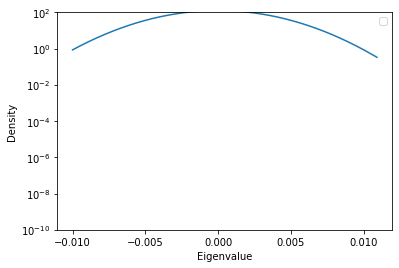

In [44]:
plot(grids, density) # 30 epochs no BN

In [45]:
print(eig_vals)

[[-2.19079984e-12  1.01370357e-09  1.52740531e-09  2.27270802e-09
   2.39562858e-09  3.24792222e-06  3.33229809e-06  3.49988773e-06
   3.62373157e-06  3.71542160e-06  3.81887094e-06  3.92773200e-06
   4.13231055e-06  4.24464406e-06  4.41967086e-06  4.68478675e-06
   4.89406875e-06  5.14584644e-06  5.43492479e-06  5.69224949e-06
   6.03878425e-06  6.24131098e-06  6.64124309e-06  6.98577787e-06
   7.27091174e-06  7.59120712e-06  7.87192857e-06  8.24261224e-06
   8.72193141e-06  9.02710781e-06  9.39864549e-06  9.88222109e-06
   1.02385839e-05  1.06187608e-05  1.09238490e-05  1.14291988e-05
   1.19263150e-05  1.21940384e-05  1.25359302e-05  1.28602815e-05
   1.33974982e-05  1.36789604e-05  1.41240125e-05  1.44289643e-05
   1.49048128e-05  1.51122304e-05  1.54910740e-05  1.58883649e-05
   1.63284567e-05  1.65162401e-05  1.68197766e-05  1.73726348e-05
   1.76054673e-05  1.77805923e-05  1.83351422e-05  1.89135753e-05
   1.95834655e-05  2.00813647e-05  2.09524751e-05  2.13373241e-05
   2.21312

In [ ]:
np.sum(density)

In [ ]:
bin_size = grids[1]-grids[0]
neg_mask = grids<0.
pos_mask = grids>0.

In [ ]:
# L1 energy
print(np.sum(bin_size*density[neg_mask]))
print(np.sum(bin_size*density[pos_mask]))

In [ ]:
# L2 energy
print(np.sum(bin_size*density[neg_mask]**2))
print(np.sum(bin_size*density[pos_mask]**2))

In [ ]:
# eigenvalue ratio
k = 10
eig_vals_s = eig_vals.reshape(-1)[::-1] # largest to smallest
print(eig_vals_s[0]/eig_vals_s[k-1])

In [ ]:
# compute covariance of Jacobian
cov = jnp.zeros_like(jax.flatten_util.ravel_pytree(state.params)[0].reshape(-1,1))
for batch in batches_list:
    def loss_fn(params):
        logits = mlp.apply({'params': params}, batch[0])
        loss = cross_entropy_loss(logits=logits, labels=batch[1])
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    grads = jax.flatten_util.ravel_pytree(grads)[0].reshape(-1,1)
    cov = cov + grads @ grads.T
cov = cov / len(batches_list)
print(cov.shape)

In [41]:
def lin_solve_sum(b_param):
    A = jnp.array(np.random.rand(5,5))
    x = jnp.linalg.solve(A,b_param)
    return jnp.sum(x)
lin_solve_sum_grad = jax.grad(lin_solve_sum)
b = jnp.array(np.random.rand(5))
lin_solve_sum_grad(b)

DeviceArray([-0.00123936,  0.6014926 ,  0.08975819,  0.2594161 ,
              0.9079218 ], dtype=float32)